# 自己組織化マップ（SOM)＆クラスタリング

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
# import PIL.Image
# import cv2

# 都道府県の自己組織化マップ

[都道府県データランキング](http://uub.jp/pdr/)

上のデータランキングのデータを適当に組合せて、kendata.csv というデータを作成した。 生データは一番下にしてある。

# １．データの読み込み

In [2]:
data = pd.read_csv("kendata.csv", delimiter=",", encoding="utf-8")  # header がない場合は header=None
#data = pd.read_csv("jinko.csv", delimiter=",", encoding="utf-8")  # header がない場合は header=None
data.head() # 上から５データ分表示

,都道府県,人口,面積,人口密度,外国人,国籍不詳率,公務員,産業動物,小動物診療
0,愛知県,7507691,5173,1451,160228,0.0103,1671,395,92
1,愛媛県,1374881,5676,242,7828,0.0058,397,123,34
2,茨城県,2907262,6097,477,40477,0.0022,1145,216,124
3,岡山県,1915401,7114,269,18476,0.0074,596,157,82
4,沖縄県,1439913,2281,631,7651,0.0057,450,177,58


データに特に深い意味はない。都道府県別の人口、面積、外国人の人数などの基礎データと、公務員より右は獣医師の人数である。
都道府県名を除く解析に使う部分の見出しを dataindex として抜き出しておく。

In [3]:
dataindex = data.columns[1:] # カラムインデックス
pref = data['都道府県'] # 都道府県名のリスト
X = data[dataindex] # SOMで対象とする学習用データ
X.head()

,人口,面積,人口密度,外国人,国籍不詳率,公務員,産業動物,小動物診療
0,7507691,5173,1451,160228,0.0103,1671,395,92
1,1374881,5676,242,7828,0.0058,397,123,34
2,2907262,6097,477,40477,0.0022,1145,216,124
3,1915401,7114,269,18476,0.0074,596,157,82
4,1439913,2281,631,7651,0.0057,450,177,58


# ２．標準化
データ X は項目ごとにデータの粒度が違うので標準化、もしくは正規化して使う。

## 標準化

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
stdX = sc.fit_transform(X) 
#  stdX には X が標準化されたデータが格納される。この操作で pandas dataframe から 普通の numpy 配列に変わる。

stdX[0:5] # 上から５つ表示

array([[ 1.77058323, -0.2539465 ,  0.66914529,  2.21006808,  1.15870098,
         1.04145165,  1.43458853,  0.02659779],
       [-0.48865647, -0.20770666, -0.3484878 , -0.48092962, -0.007721  ,
        -0.53972541, -0.59437261, -0.3452257 ],
       [ 0.07585083, -0.16900493, -0.15068484,  0.09556896, -0.94085858,
         0.38862659,  0.09935307,  0.23174178],
       [-0.28953661, -0.07551405, -0.3257615 , -0.29291293,  0.40700682,
        -0.29274406, -0.34075247, -0.03750971],
       [-0.46469961, -0.51980258, -0.02106078, -0.48405499, -0.03364148,
        -0.47394646, -0.19156415, -0.1913677 ]])

# ３．SOM のメソッドを定義

In [5]:
import scipy.stats as st
# ガウス分布
def gkern(kernlen=21, nsig=3):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

# 自己組織化マップ SOM を生成する　　　　M :２次元配置されたニューロンの重み配列    x : 入力データ,  alpha：学習係数
def organize_som(M, x, alpha=0.3, ksize=3):
    gk = gkern(2*ksize+1,ksize)/np.max(gkern(2*ksize+1,ksize))
    mini, minj = get_winner(M,x)
    dim = x.shape[0]
    MM = np.zeros((M.shape[0]+2*ksize, M.shape[1]+2*ksize,dim),np.float64)
    MM[ksize:-ksize,ksize:-ksize]=M
    for i in range(-ksize,ksize+1): #  勝者の近傍7x7 の範囲を与えられたデータ（このプログラムでは色）に近づける
        for j in range(-ksize,ksize+1):
            try:
                MM[ksize+mini+i,ksize+minj+j] += alpha * (x - MM[ksize+mini+i,ksize+minj+j])*gk[ksize+i,ksize+j]
            except:
                pass
    return MM[ksize:-ksize,ksize:-ksize]

# 境界の描画
def plotBoundary(labels, somcenters,cmap='Pastel1'):
    row = labels.shape[0]
    col = labels.shape[1]
    
    YY,XX = np.mgrid[0:row, 0:col] # make a grid    
    
    plt.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10) 
            
    for index, p in enumerate(somcenters):
        plt.text(p[1],p[0],str(index),ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.3, lw=0))

# Map M において、ベクトルｘともっとも近い重みベクトルを持つノードの座標を得る
def get_winner(M,x):
    col =  M.shape[1]
    # row =  M.shape[0]
    min_i = np.argmin(((M-x)**2).sum(axis=2)) 
    mini = min_i // col # argmin は1次元化した番号が返ってくるので　2次元化
    minj = min_i % col
    return mini, minj


# ４．メインプログラムの実行

In [6]:
# メインプログラム
row = 20  # 高さ
col = 30 # 幅
learntime = 256# 繰り返し学習回数
alpha = 0.3 # 学習係数

W = np.random.random([row,col,len(dataindex)]) # Map 用の配列

for time in range(learntime):
    for color in stdX:
        W=organize_som(W, color,alpha=alpha,ksize=5) # 競合学習の実行


このマップは20ｘ30個のRGBのデータ集合だと考えられる。

上のブロックの実行で，SOMは配列Wとして生成されているが，個々のニューロンは８次元ベクトルなのでそのままでは表示できない．

この600個のデータをK-Means法でクラスタリングし，クラスタにカラーを割り当てて表示することにしよう．


# ５．クラスタリング
## ５．１　クラスタリングのプログラム


In [7]:
from sklearn.cluster import KMeans

def kmeans(M,k,itr):   # 配列Mの要素を対象として k-Means 法でクラスタリングを実行する　　k クラスタ数、 itr 繰り返し処理回数
    row = M.shape[0]
    col = M.shape[1]
    ch = M.shape[2]
    data = M.reshape(col*row,ch)
    km = KMeans(n_clusters=k,init='random',n_init=1,max_iter=itr,random_state=1)
    labelimage = (km.fit(data).labels_).reshape(row,col)
    centers = km.cluster_centers_
    return labelimage, centers 

# 都道府県名の描画
def writePref(W, pref, data, dataindex):
     for index, pname in enumerate(pref):
        d1 =  np.array(data[index])
        (y,x)= get_winner(W,d1)
        plt.text(x,y,pref.loc[index],ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.2, lw=0))   

# 5.2　クラスタリング実験
##  （１）データをk-means法で３分割

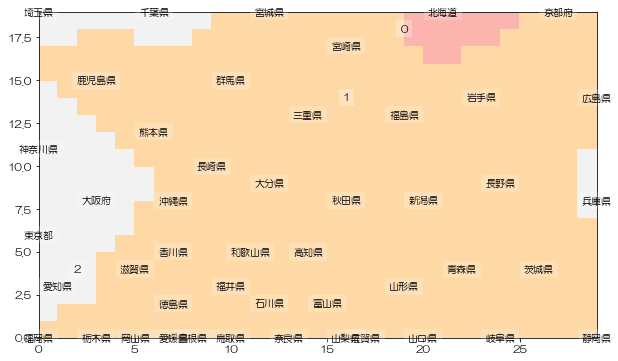

In [8]:
# 3-means
labelimage, centers = kmeans(W,3,100)
somcenters = [get_winner(W,c) for c in centers]
plt.rcParams['font.family'] = 'HGMaruGothicMPRO'
fig = plt.figure(figsize=(10,6))
plotBoundary(labelimage, somcenters)
writePref(W,pref,stdX,dataindex)

# （２）データをk-means法で5分割


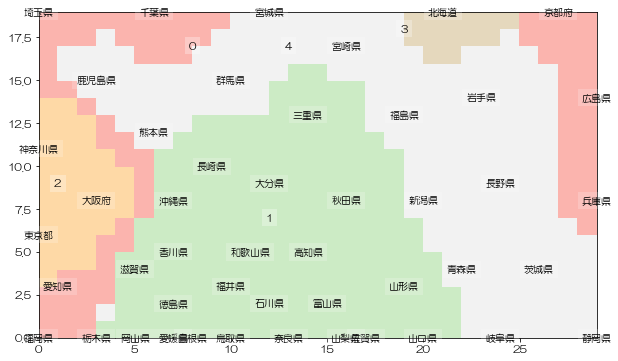

In [9]:
# 5-means
labelimage, centers = kmeans(W,5,100)
somcenters = [get_winner(W,c) for c in centers]
fig = plt.figure(figsize=(10,6))
plotBoundary(labelimage, somcenters)
writePref(W,pref,stdX,dataindex)

# （２）データをk-means法で8分割

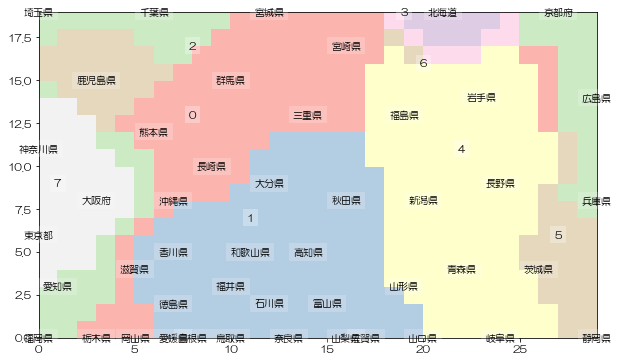

In [10]:
# 8-means
labelimage, centers = kmeans(W,8,100)
somcenters = [get_winner(W,c) for c in centers]
fig = plt.figure(figsize=(10,6))
plotBoundary(labelimage, somcenters)
writePref(W,pref,stdX,dataindex)

In [11]:
with open("kendata.csv", encoding="utf-8") as f:
    print(f.read())

﻿都道府県,人口,面積,人口密度,外国人,国籍不詳率,公務員,産業動物,小動物診療
愛知県,7507691 ,5173 ,1451 ,160228 ,0.0103 ,1671 ,395 ,92 
愛媛県,1374881 ,5676 ,242 ,7828 ,0.0058 ,397 ,123 ,34 
茨城県,2907262 ,6097 ,477 ,40477 ,0.0022 ,1145 ,216 ,124 
岡山県,1915401 ,7114 ,269 ,18476 ,0.0074 ,596 ,157 ,82 
沖縄県,1439913 ,2281 ,631 ,7651 ,0.0057 ,450 ,177 ,58 
岩手県,1268083 ,15275 ,83 ,5184 ,0.0019 ,628 ,137 ,162 
岐阜県,2022785 ,10621 ,190 ,36879 ,0.0032 ,664 ,215 ,36 
宮崎県,1095959 ,7735 ,142 ,3802 ,0.0034 ,652 ,226 ,209 
宮城県,2329431 ,7282 ,320 ,12367 ,0.0043 ,653 ,199 ,125 
京都府,2605731 ,4612 ,565 ,41855 ,0.0139 ,649 ,151 ,19 
熊本県,1774538 ,7409 ,240 ,7624 ,0.0062 ,655 ,187 ,126 
群馬県,1966381 ,6362 ,309 ,35458 ,0.0042 ,647 ,186 ,107 
広島県,2838494 ,8479 ,335 ,31882 ,0.0118 ,717 ,205 ,63 
香川県,972156 ,1877 ,518 ,6858 ,0.0079 ,343 ,104 ,29 
高知県,720907 ,7104 ,101 ,3172 ,0.0042 ,259 ,91 ,19 
佐賀県,828388 ,2441 ,339 ,3594 ,0.0027 ,255 ,98 ,34 
埼玉県,7288081 ,3798 ,1919 ,88734 ,0.0071 ,1967 ,345 ,73 
三重県,1807611 ,5774 ,313 ,32825 ,0.0051 ,455 ,149 ,39 
山形県,